# Enhancing Khmer Sentiment Analysis Using Transformer Models

# Install Dependencies

## For Word Segmentation

In [ ]:
! git clone https://github.com/rinabuoy/KhmerNLP

fatal: destination path 'KhmerNLP' already exists and is not an empty directory.


In [ ]:
%cd KhmerNLP

/content/KhmerNLP


In [ ]:
!pip install sklearn_crfsuite

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 25.4 MB/s eta 0:00:00


In [ ]:
import os
from transformers import TFAutoModel,AutoTokenizer,BertModel,AdamW,XLMRobertaTokenizer,XLMRobertaForSequenceClassification, Trainer, TrainingArguments,XLMRobertaModel
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from sklearn.metrics import classification_report, confusion_matrix
#from khmerwordsegmentor import KhmerWordSegmentor
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm

# Load Data and Preprocessing

In [ ]:
data = pd.read_csv('/content/kh_sentiment_data_segmented (1).csv')

In [ ]:
data.head(10)

,ID,Text,Sentiment_text,Sentiment_label,seg_text_lstm,seg_text_crf
0,1,ខ្ញុំចូលចិត្តវា,Positive,1.0,ខ្ញុំ ចូលចិត្ត វា,ខ្ញុំ ចូលចិត្ត វា
1,2,ផលិតផលនេះគុណភាពល្អ,Positive,1.0,ផលិតផល នេះ គុណភាព ល្អ,ផលិតផល នេះ គុណភាព ល្អ
2,3,ប្រើប្រាស់មិនបានយូ ហើយថ្លៃទៀត,Negative,0.0,ប្រើប្រាស់ មិន បាន យូហើយ ថ្លៃ ទៀត,ប្រើប្រាស់ មិន បាន យូហើយ ថ្លៃ ទៀត
3,4,នៅតែពេញនិយមស្តាប់មិនធុញ,Positive,1.0,នៅតែ ពេញនិយម ស្តាប់ មិន ធុញ,នៅតែ ពេញនិយម ស្តាប់ មិន ធុញ
4,5,ខ្ញុំអត់ចូលចិត្តត្រង់ កាមេរ៉ា មហាអន់ និយាយមែន,Negative,0.0,ខ្ញុំ អត់ ចូលចិត្ត ត្រង់ កាមេរ៉ា មហា អន់ និយាយ...,ខ្ញុំ អត់ ចូលចិត្ត ត្រង់ កាមេរ៉ា មហា អន់ និយាយ...
5,6,ខ្ញុំអត់ពេញចិត្តរូប១សន្លឹកដែលថតនោះ,Negative,0.0,ខ្ញុំ អត់ ពេញចិត្ត រូប ១ សន្លឹក ដែល ថត នោះ,ខ្ញុំ អត់ ពេញចិត្ត រូប ១ សន្លឹក ដែល ថត នោះ
6,7,ផលិតបានល្អខ្លាំងណាស់,Positive,1.0,ផលិត បាន ល្អ ខ្លាំង ណាស់,ផលិត បាន ល្អ ខ្លាំង ណាស់
7,8,ខ្ញុំស្ដាប់10ដងហើយនៅតែពិរស់,Positive,1.0,ខ្ញុំ ស្ដាប់ 10 ដង ហើយ នៅតែ ពិរស់,ខ្ញុំ ស្ដាប់ 10 ដង ហើយ នៅតែ ពិរស់
8,9,អ្នកបើកបរមានសុជីវធម៍ល្អ លើកក្រោយចង់ជិះជាមួយគាត...,Positive,1.0,អ្នកបើកបរ មាន សុជីវធម៍ ល្អ លើក ក្រោយ ចង់ ជិះ ជ...,អ្នកបើកបរ មាន សុជីវធម៍ ល្អ លើក ក្រោយ ចង់ ជិះ ជ...
9,10,សូមខំមិនរឿងអ្នកបើកបរម្សិលមិញពីសៀមរាបមកភ្នំពេញម...,Negative,0.0,សូម ខំ មិន រឿង អ្នកបើកបរ ម្សិលមិញ ពី សៀមរាប មក...,សូម ខំ មិន រឿង អ្នកបើកបរ ម្សិលមិញ ពី សៀមរាប មក...


In [ ]:
data.isna().sum() #missing value

,0
ID,0
Text,0
Sentiment_text,0
Sentiment_label,0
seg_text_lstm,0
seg_text_crf,0


In [ ]:
data['Sentiment_label'].value_counts() # Check class label, prevent from imbalance class

,count
Sentiment_label,
1.0,599
0.0,515


# Word Segmentation

In [ ]:
# Initialize the segmentor
seg = KhmerWordSegmentor()
def segment_khmer_text(text, model="lstm"):
    """
    Segment Khmer text using the specified model (LSTM or CRF).

    Parameters:
        text (str): The input Khmer text to be segmented.
        model (str): The model to use for segmentation ('lstm' or 'crf').

    Returns:
        str: The segmented text as a string.
    """
    try:
        # Segment the text
        segmented_text = seg.segment(text, model=model)
        return segmented_text
    except Exception as e:
        print(f"Error during segmentation: {e}")
        return ""

Inference on GPU!


/content/KhmerNLP/khmerwordsegmentor.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.bilstmModel = torch.load(bilstm_model_path)


In [ ]:
data['seg_text_lstm'] = data['Text'].apply(lambda x: segment_khmer_text(x, model='lstm')) # apply word segmentation using "LSTM"
data['seg_text_crf'] = data['Text'].apply(lambda x: segment_khmer_text(x,model = 'crf')) # apply word segmentation using "CRF"

In [ ]:
data.head(10)

,ID,Text,Sentiment_text,Sentiment_label,seg_text_lstm,seg_text_crf
0,1,ខ្ញុំចូលចិត្តវា,Positive,1.0,ខ្ញុំ ចូលចិត្ត វា,ខ្ញុំ ចូលចិត្ត វា
1,2,ផលិតផលនេះគុណភាពល្អ,Positive,1.0,ផលិតផល នេះ គុណភាព ល្អ,ផលិតផល នេះ គុណភាព ល្អ
2,3,ប្រើប្រាស់មិនបានយូ ហើយថ្លៃទៀត,Negative,0.0,ប្រើប្រាស់ មិន បាន យូហើយ ថ្លៃ ទៀត,ប្រើប្រាស់ មិន បាន យូហើយ ថ្លៃ ទៀត
3,4,នៅតែពេញនិយមស្តាប់មិនធុញ,Positive,1.0,នៅតែ ពេញនិយម ស្តាប់ មិន ធុញ,នៅតែ ពេញនិយម ស្តាប់ មិន ធុញ
4,5,ខ្ញុំអត់ចូលចិត្តត្រង់ កាមេរ៉ា មហាអន់ និយាយមែន,Negative,0.0,ខ្ញុំ អត់ ចូលចិត្ត ត្រង់ កាមេរ៉ា មហា អន់ និយាយ...,ខ្ញុំ អត់ ចូលចិត្ត ត្រង់ កាមេរ៉ា មហា អន់ និយាយ...
5,6,ខ្ញុំអត់ពេញចិត្តរូប១សន្លឹកដែលថតនោះ,Negative,0.0,ខ្ញុំ អត់ ពេញចិត្ត រូប ១ សន្លឹក ដែល ថត នោះ,ខ្ញុំ អត់ ពេញចិត្ត រូប ១ សន្លឹក ដែល ថត នោះ
6,7,ផលិតបានល្អខ្លាំងណាស់,Positive,1.0,ផលិត បាន ល្អ ខ្លាំង ណាស់,ផលិត បាន ល្អ ខ្លាំង ណាស់
7,8,ខ្ញុំស្ដាប់10ដងហើយនៅតែពិរស់,Positive,1.0,ខ្ញុំ ស្ដាប់ 10 ដង ហើយ នៅតែ ពិរស់,ខ្ញុំ ស្ដាប់ 10 ដង ហើយ នៅតែ ពិរស់
8,9,អ្នកបើកបរមានសុជីវធម៍ល្អ លើកក្រោយចង់ជិះជាមួយគាត...,Positive,1.0,អ្នកបើកបរ មាន សុជីវធម៍ ល្អ លើក ក្រោយ ចង់ ជិះ ជ...,អ្នកបើកបរ មាន សុជីវធម៍ ល្អ លើក ក្រោយ ចង់ ជិះ ជ...
9,10,សូមខំមិនរឿងអ្នកបើកបរម្សិលមិញពីសៀមរាបមកភ្នំពេញម...,Negative,0.0,សូម ខំ មិន រឿង អ្នកបើកបរ ម្សិលមិញ ពី សៀមរាប មក...,សូម ខំ មិន រឿង អ្នកបើកបរ ម្សិលមិញ ពី សៀមរាប មក...


In [ ]:
data.to_csv('kh_sentiment_data_segmented.csv', index=False)

In [ ]:
data = data[['seg_text_lstm', 'Sentiment_label']] # Use segmented text column and sentiment label

# Split into train and validation sets
train_data, val_data = train_test_split(data, test_size=0.2)

# Tokenization

In [ ]:
# Load the XLM-Roberta tokenizer
tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-base")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

# Create a customer dataset using Pytorch

In [ ]:
#Custom Dataset class
class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length):
        self.dataframe = dataframe
        self.texts = dataframe['seg_text_lstm'].tolist()
        self.labels = dataframe['Sentiment_label'].tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        # Tokenize the text
        encoded = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt",
        )

        # Return tensors
        return {
            'input_ids': encoded['input_ids'].squeeze(0),  # Remove batch dimension
            'attention_mask': encoded['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }



In [ ]:
# Define parameters
max_length = 128  # Maximum token length
batch_size = 16   # Batch size

# Create datasets
train_dataset = CustomDataset(train_data, tokenizer, max_length)
val_dataset = CustomDataset(val_data, tokenizer, max_length)

In [ ]:
# Retrieve the first sample
sample = train_dataset[0]
# Print the tokenized data
print("Input IDs:", sample['input_ids'])
print("Attention Mask:", sample['attention_mask'])
print("Label:", sample['label'])

Input IDs: tensor([     0,   3345, 197111,   5580,  54118,  13227,  47760,      6, 197380,
             6, 114918,      2,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      

In [ ]:
# Create dataloaders
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_data_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Define Pre-train Model

In [ ]:
class XLMRClassifier(nn.Module):
    def __init__(self, model_name, num_classes):
        super(XLMRClassifier, self).__init__()
        self.xlm_roberta = XLMRobertaModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.1)

        # For binary classification, output 2 logits (for class 0 and 1)
        self.fc = nn.Linear(self.xlm_roberta.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.xlm_roberta(input_ids=input_ids, attention_mask=attention_mask)

        # Extract the [CLS] token representation
        pooled_output = outputs[0][:, 0, :]

        # Apply dropout and fully connected layer
        x = self.dropout(pooled_output)
        logits = self.fc(x)

        return logits


# Training

In [ ]:

# Initialize the model
model = XLMRClassifier(model_name='xlm-roberta-base', num_classes=2)

# Define the optimizer and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00001)
criterion = torch.nn.CrossEntropyLoss()  # For classification tasks


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

In [ ]:
# Initialize a list to store loss history
loss_history = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0

    # tqdm for showing the progress bar
    for batch in tqdm(train_data_loader, desc=f"Epoch {epoch + 1}/{epochs}"):
        optimizer.zero_grad()

        # Get input and output from the batch
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        # Get logits (the first element of the tuple)
        logits = outputs

        # Compute loss
        loss = criterion(logits, labels)

        # Backpropagation
        loss.backward()

        # Update parameters
        optimizer.step()

        running_loss += loss.item()

    # Compute the average loss for this epoch
    epoch_loss = running_loss / len(train_data_loader)
    loss_history.append(epoch_loss)  # Save the loss for this epoch
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}")

Epoch 1/10: 100%|██████████| 56/56 [00:24<00:00,  2.31it/s]


Epoch 1/10, Loss: 0.7521


Epoch 2/10: 100%|██████████| 56/56 [00:22<00:00,  2.55it/s]


Epoch 2/10, Loss: 0.7214


Epoch 3/10: 100%|██████████| 56/56 [00:22<00:00,  2.46it/s]


Epoch 3/10, Loss: 0.6855


Epoch 4/10: 100%|██████████| 56/56 [00:23<00:00,  2.42it/s]


Epoch 4/10, Loss: 0.5907


Epoch 5/10: 100%|██████████| 56/56 [00:22<00:00,  2.44it/s]


Epoch 5/10, Loss: 0.5687


Epoch 6/10: 100%|██████████| 56/56 [00:22<00:00,  2.47it/s]


Epoch 6/10, Loss: 0.4943


Epoch 7/10: 100%|██████████| 56/56 [00:22<00:00,  2.47it/s]


Epoch 7/10, Loss: 0.4436


Epoch 8/10: 100%|██████████| 56/56 [00:22<00:00,  2.46it/s]


Epoch 8/10, Loss: 0.3980


Epoch 9/10: 100%|██████████| 56/56 [00:22<00:00,  2.47it/s]


Epoch 9/10, Loss: 0.4157


Epoch 10/10: 100%|██████████| 56/56 [00:22<00:00,  2.47it/s]

Epoch 10/10, Loss: 0.4151


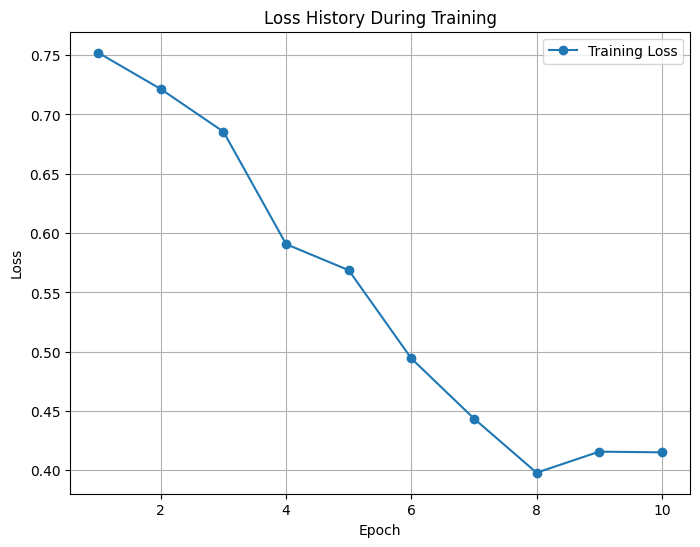

In [ ]:
# Plot the loss history
plt.figure(figsize=(8, 6))
plt.plot(range(1, epochs + 1), loss_history, marker='o', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss History During Training')
plt.legend()
plt.grid(True)
plt.show()

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.52      0.59       110
           1       0.62      0.78      0.69       113

    accuracy                           0.65       223
   macro avg       0.66      0.65      0.64       223
weighted avg       0.66      0.65      0.64       223

Confusion Matrix:
[[57 53]
 [25 88]]


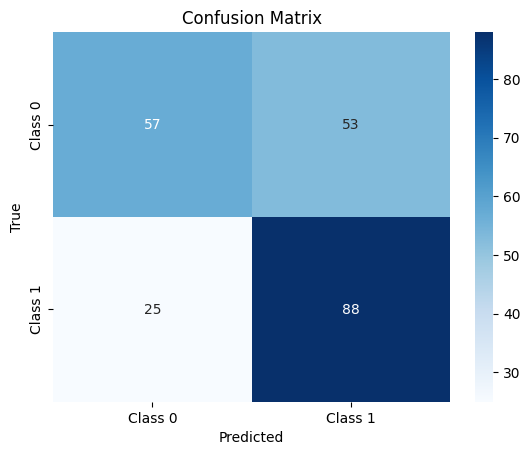

In [ ]:
# Set model to evaluation mode
model.eval()

# Lists to store predictions and true labels
all_preds = []
all_labels = []

# Disable gradient computation for evaluation
with torch.no_grad():
    for batch in val_data_loader:
        # Send inputs and labels to the device (GPU/CPU)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        # Forward pass through the model
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        # Extract logits and compute predictions
        logits = outputs
        _, preds = torch.max(logits, dim=1)

        # Store predictions and true labels
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Print the classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds))

# Print the confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))

# Visualization of the confusion matrix
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

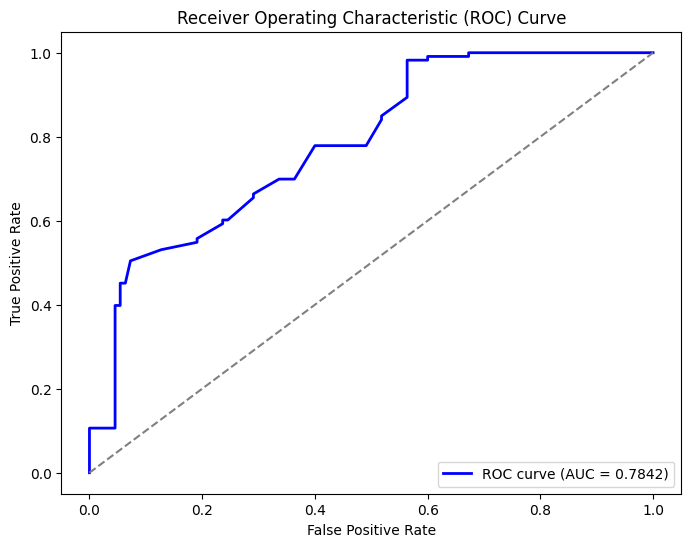

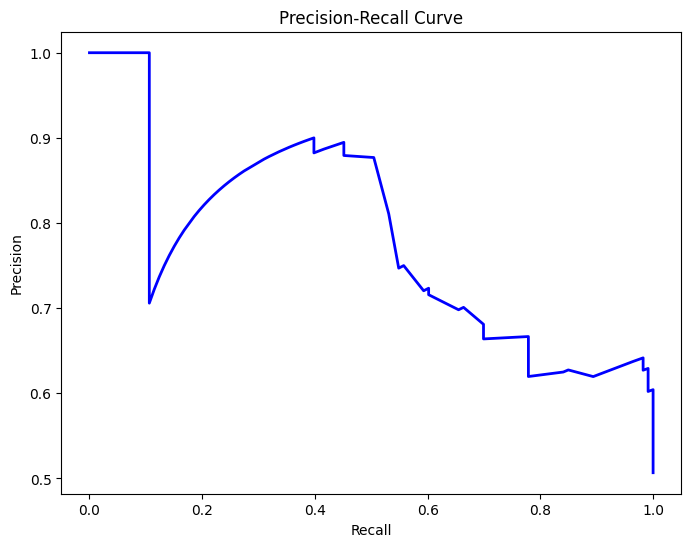

AUC: 0.7842


In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt

# Extract probabilities for the positive class (class 1)
all_probs = []

# Disable gradient computation for evaluation
with torch.no_grad():
    for batch in val_data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        # Forward pass through the model
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        logits = outputs
        probs = torch.softmax(logits, dim=1)  # Convert logits to probabilities
        all_probs.extend(probs.cpu().numpy()[:, 1])  # Get probabilities for class 1

# AUC Calculation
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(all_labels, all_probs)

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# Print AUC score
print(f"AUC: {roc_auc:.4f}")

In [ ]:
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(all_labels, all_preds)
print(f"MCC: {mcc:.4f}")


MCC: 0.6046


In [ ]:
# Save the entire model
model_save_path = "xlmr_sentiment_model_full.pth"
torch.save(model, model_save_path)
print(f"Model saved to {model_save_path}")


Model saved to xlmr_sentiment_model_full.pth
